# EMPIRICAL MACROECONOMICS
Francesco Franco, Nova SBE
## Class 2 Fundamental Shocks: Replication of Blanchard and Quah AER 1989 
**The Dynamic Effects of Aggregate Demand and Supply Disturbances Olivier Jean Blanchard and Danny Quah. The American Economic Review , Vol. 79, No. 4 (Sep., 1989), pp. 655-673**

Refer to paper and class notes


In [1]:
'''
Importing packages and functions
''' 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
from pandas_datareader.data import DataReader 
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from scipy import signal
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from scipy.optimize import root
%matplotlib inline

/anaconda3/envs/ClassEM/lib/python3.6/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
'''
Downloading and preparing data using DataReader
'''
           
#Sample selection
start = '1948Q1'                                              
end = '1987Q3'

#Data from FRED
gdp = DataReader('GNPC96', 'fred', start=start,  end=end) # quarterly frequency
urate = DataReader('UNRATE', 'fred', start=start, end=end)  # monthly frequency

In [3]:
'''
Transforming the data part 1
'''

#Frequency change for urate
urateq = urate.resample('Q').mean() # Convenience method for frequency conversion and resampling of time series. 
                                    # Object must have a datetime-like index 
#urateq = urate.groupby(pd.PeriodIndex(urate.index, freq='Q'), axis=0).mean()

#From YYYYQ format to date format (find it important for matplotlib)
gdp.index = pd.date_range(start,'1987Q4',freq="Q")
urateq.index = pd.date_range(start,'1987Q4',freq="Q")

#create Data Frame
df = pd.concat((urateq, gdp), axis=1)
df.columns = ["urate","gdp"]
df["lngdp"] = np.log(df["gdp"])
df["dy"] = (df["lngdp"] - df["lngdp"].shift(1))*400 #annualized quarterly GDP growth
df = df[1:] # drop first observation

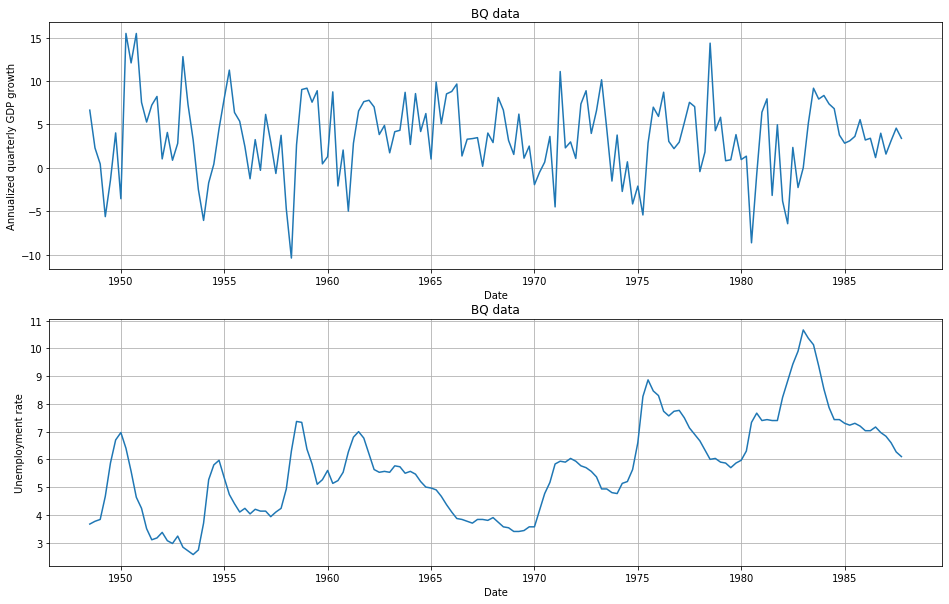

In [4]:
'''
Plot original data
'''

plt.figure(figsize=(16,10))
plt.subplot(211)
plt.plot(df["dy"])
plt.xlabel('Date')
plt.ylabel('Annualized quarterly GDP growth')
plt.title('BQ data')
plt.grid()
plt.subplot(212)
plt.plot(df["urate"])
plt.xlabel('Date')
plt.ylabel('Unemployment rate')
plt.title('BQ data')
plt.grid()
plt.show()

In [5]:
'''
Transforming the data part 2
'''

# Detrending as in the paper: Important to make the data covariance stationary
# Productivity Slowdown less apparent than in origal data, upward trend in urate present

df.loc[:"1973Q2","dys"] = signal.detrend(df.loc[:"1973Q2","dy"],type="constant")
df.loc["1973Q3":,"dys"] = signal.detrend(df.loc["1973Q3":,"dy"],type="constant")
df["urates"] = signal.detrend(df["urate"])

In [6]:
#?signal.detrend

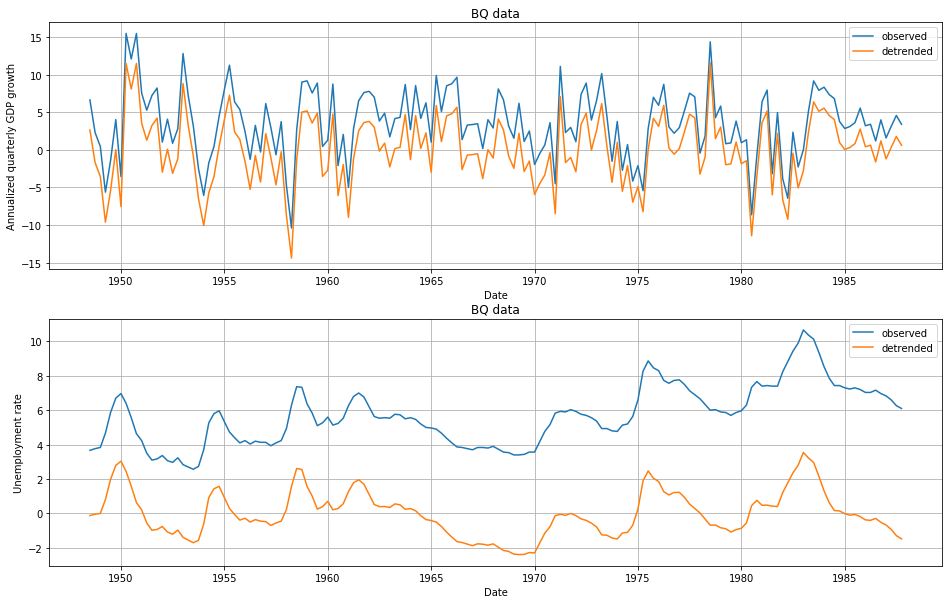

In [7]:
'''
Plot original data & detrended data
'''

plt.figure(figsize=(16,10))
plt.subplot(211)
plt.plot(df['dy'],label='observed')
plt.plot(df['dys'],label='detrended')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Annualized quarterly GDP growth')
plt.title('BQ data')
plt.grid()
plt.subplot(212)
plt.plot(df['urate'],label='observed')
plt.plot(df['urates'],label='detrended')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Unemployment rate')
plt.title('BQ data')
plt.grid()
plt.show()

## Estimation part 1

In [8]:
#Setting up the data for VAR
X = df.loc[:,["dys","urates"]].copy()

### Reduced form VAR code
$$X_t=\hat{B}(1)X_{t-1} + \hat{B}(2)X_{t-2} + ... + \epsilon_t$$

where $X_t$ is $n\times 1$ matrix of data and where $\hat{B}(i)$ is a $n\times n$ matrix of coefficients.
Note that we do not put a constant since the variabes are detrended 
(so have mean 0 over the sample period)


In [9]:
# If we were lazy....
# we could use the statistical package statsmodel
# this creates a model VAR which has a lot of methos availabe for example fit
# Actually it is a fantastic package check it out.
model = VAR(X)
results = model.fit(8,trend='nc')
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 12, Apr, 2020
Time:                     10:06:45
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   0.511799
Nobs:                     150.000    HQIC:                  0.130464
Log likelihood:          -383.896    FPE:                   0.879115
AIC:                    -0.130469    Det(Omega_mle):        0.717814
--------------------------------------------------------------------
Results for equation dys
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
L1.dys            0.062713         0.114362            0.548           0.583
L1.urates        -3.625091         1.420617           -2.552           0.011
L2.dys            0.098538         0.118476            0.832           0.406
L

In [10]:
results.coefs.shape

(8, 2, 2)

In [11]:
%timeit -r 7 -n 100 results = model.fit(8,trend='nc') # is it fast?

2.1 ms ± 120 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Test specification
We must run battery of tests to be sure your specifiaction is correct
$$FPE=\left|\Omega\right|\left(\frac{T+Kp+1}{T+Kp-1}\right)^{K}$$
$$AIC=-2\left(\frac{\mathcal{L}}{T}\right)+2\frac{t_{p}}{T}$$
$$SBIC=-2\left(\frac{\mathcal{L}}{T}\right)+2\frac{ln(T)}{T}t_{p}$$
$$HQIC=-2\left(\frac{\mathcal{L}}{T}\right)+\frac{2ln(ln(T))}{T}t_{p}$$

Notice that statsmodels produce different values of the above statistics

In [12]:
'''
Lag selection in statsmodels
'''
model.select_order(12,trend='nc').summary()

,AIC,BIC,FPE,HQIC
0,-0.08834,-0.006595,0.9155,-0.05512
1,-0.2254,-0.06190,0.7982,-0.1590
2,-0.2570,-0.01178*,0.7734,-0.1574*
3,-0.2332*,0.09375,0.7922*,-0.1004
4,-0.1952,0.2136,0.8231,-0.02909
5,-0.2049,0.2855,0.8153,-0.005666
6,-0.1593,0.4129,0.8537,0.07318
7,-0.1173,0.5366,0.8909,0.1484
8,-0.1272,0.6085,0.8828,0.1717
9,-0.1285,0.6889,0.8825,0.2037


In [13]:
'''
The formulas are different as they use the fact that loglikehood is related to determinant
'''
AIC = -2*(results.llf/150)+2*32/150
AIC2 = AIC-2*np.log(2*np.pi)-2  # relation with statsmodel formula
print(AIC)
print(AIC2)

5.545284742557712
-0.1304693902609788


But we are not lazy...(in reality we need to learn).
We can write the model in a bigger one and use OLS which is equivalent to Maximum Likelihood for an unrestricted VAR
$$X = X_L\hat{B} + EPS$$
where $X$ is $T\times n$,$X_L$ is $T\times (n\times p)$ and $\hat{B}$ is $(n\times p) \times n$

$\hat{B}$ = $[\hat{B}(1)...\hat{B}(p)]$

Sometimes it is written as as $$X'=\hat{B}'X_L'+EPS'$$


In [14]:
'''
VAR with a OLS
'''
XLAG = pd.DataFrame()
num_lags = 8 
for i in range(1,num_lags+1):
    XLAG = pd.concat([XLAG,X.shift(i).add_suffix("-"+str(i))],axis=1)
#change names to frames that we modify    
X2 = X.iloc[num_lags:,:]
XLAG2 = XLAG.iloc[num_lags:,:]
num_vars = X2.shape[1]
num_obs = XLAG2.shape[0]

#changing to arrays 
X3 = np.array(X2)
XLAG3 = np.array(XLAG2)

#VAR - standard OLS
Bhat = inv(XLAG3.T@XLAG3)@XLAG3.T@X3

In [15]:
Bhat.shape

(16, 2)

In [16]:
pd.DataFrame(Bhat)

,0,1
0,0.062713,-0.030227
1,-3.625091,1.316123
2,0.098538,-0.028506
3,7.291284,-0.633486
4,0.002013,-0.019718
5,-2.986615,0.131227
6,0.160463,-0.009325
7,3.198425,-0.066035
8,0.096720,0.001165
9,-3.067808,0.213197


In [17]:
'''
We can build our own VAR Class
And we have options in how to program it
here with numpy
'''
class VAR_np_class():
    
    def __init__(self,X,lags):
        self.X = X
        self.lags = lags
        
    def XLAGp(self):       
        XLAG     = np.vstack((np.empty((1,2)),self.X[0:-1,:]))
        for i in range(2,self.lags+1):
            tmp1 = np.vstack((np.empty((i,2)),self.X[0:-i,:]))
            XLAG = np.hstack((XLAG,tmp1))
        X2 = self.X[self.lags:,:]
        XLAG2    = XLAG[self.lags:,:]
        return X2, XLAG2
    
    def fit(self):
        X2, XLAG2 = self.XLAGp()
        Bhat = inv(XLAG2.T@XLAG2)@XLAG2.T@X2
        return Bhat    

In [18]:
'''
We can build our own VAR Class
here with pandas
'''
class VAR_pd_class():
    
    def __init__(self,X,lags):
        self.X = X
        self.lags = lags
        
    def XLAGp(self):
        XLAG = pd.DataFrame()
        for i in range(2,self.lags+1):
            XLAG = pd.concat([XLAG,self.X.shift(i).add_suffix("-"+str(i))],axis=1)
        X2       = X.iloc[self.lags:,:]
        XLAG2    = XLAG.iloc[self.lags:,:]
        return X2, XLAG2
    
    def fit(self):
        X2, XLAG2 = self.XLAGp()
        X3 = np.array(X2)
        XLAG3 = np.array(XLAG2)
        Bhat = inv(XLAG3.T@XLAG3)@XLAG3.T@X3
        return Bhat

In [19]:
prova = VAR_np_class(X.values,8)

In [20]:
prova2 = VAR_pd_class(X,8)

In [21]:
%timeit -r 7 -n 100 prova.fit()

164 µs ± 30.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [22]:
%timeit -r 7 -n 100 prova2.fit()

9.73 ms ± 66.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [23]:
'''
which is faster?
1 millisecond =
1000 microseconds
'''
Statsmodels = 2.17*1000
VAR_np = 157
VAR_pd = 9.91*1000
print(Statsmodels/VAR_np)
print(VAR_pd/Statsmodels)

13.821656050955413
4.566820276497696


#### Canonical form
$$X_{t}=B(1)X_{t-1}+B(2)X_{t-2}+...+B(p)X_{t-p}+v_{t}$$


$$\left[\begin{array}{c}
X_{t}\\
X_{t-1}\\
...\\
X_{t-p}
\end{array}\right]=\left[\begin{array}{cccc}
B(1) & B(2) & ... & B(p)\\
I_{n} & 0 & ... & 0\\
0 & I_{n} & ... & 0\\
0 & 0 & ... & 0
\end{array}\right]\left[\begin{array}{c}
X_{t-1}\\
X_{t-2}\\
...\\
X_{t-p-1}
\end{array}\right]+...+\left[\begin{array}{c}
I_{n}\\
0\\
0\\
0
\end{array}\right]v_{t}$$

$$X_{t}^{c}=B^{c}X_{t-1}^{c}+G^{c}v_{t}$$

$$X_{t}^{c}=(I-B^{c}L)^{-1}G^{c}v_{t}$$

You have to work with the first *n* rows

In [24]:

# Putting problem in canonical form (VAR(8) into VAR(1))
# c_x(t) = c_Bhat*c_x(t-1) + c_G*eta(t)
# c_Bhat = [ Bhat' ; eye((n_lags-1)*n_vars) zeros((n_lags-1)*n_vars,n_vars) ] ;

c_Bhat = np.vstack((Bhat.T,np.hstack((np.identity((num_lags-1)*num_vars),
                                      np.zeros([(num_lags-1)*num_vars,num_vars]))))) 

#Setting up for LR restriction
c_Mhat = inv(np.identity(c_Bhat.shape[0])-c_Bhat)
Mhat = c_Mhat[:2,:2]

#### Identification
Now let us apply our identification restrictions to the covariance matrix of the estimated innovations $v=A(0)\epsilon$
1. $\epsilon\epsilon'=I$ therefore $\Omega=A(0)A(0)'$, gives us three restrictions
2. $LR_{11}=0$ where $LR=(I+C(1)+C(2)+...)A(0)=(I-C)^{-1}A(0)$, gives us one restriction.
In our code denote $(I-C)^{-1}$ as Mhat

In [25]:
'''
Construct Omega
'''
#Estimated errors
EPS = (X3 - XLAG3@Bhat)
#estimated covariance matrix
Omegahat = EPS.T@EPS/(num_obs - num_lags*num_vars)

In [26]:
'''
objective function to impose restrictions on the variance covariance matrix
of the estimated reduced form, starts with x0, outputs H,
which it uses again as x0 until convergence
'''
def objective(x0,Mhat,Omegahat,num_vars):   
    
    A0   = np.reshape(x0,[num_vars,num_vars]) #grab starting values, and create a possible matrix  A(0)
    LR  = Mhat@A0                             #LR effect given by multiplication of Mhat and A0
    H   = A0@A0.T - Omegahat                  #A(0)*A(0).T should be equal to Omegahat, 
                                              #as variance of shocks is identity
    H[0,1] = LR[0,1]                          #We add LR restriction
    H = H.flatten()
    return H #each parameter in H must be equal to 0, including LR restriction

In [27]:
'''
solve the system of equation to find the structural parameters
'''
x0 = ((Omegahat**2)**.25).flatten() #Starting values, flatten is needed for root function below
#returns the values of G, A(0), which guarantee LR restriction = 0,
#as well as the information from variance-covariance matrix
sol = root(objective,x0,args=(Mhat,Omegahat,num_vars)) # Solves F(X) = 0, where both X and 0 can be vectors
A0   = sol.x.reshape([num_vars,num_vars]) 
#the first shock (supply) should have a positive impact on output (only redefines direction, and changes nothing)
if A0[0,0] < 0: A0[:,0] = -A0[:,0]
#the second shock (demand) should have a positive impact on output (only redefines direction, and changes nothing)
if A0[0,1] < 0: A0[:,1] = -A0[:,1]
#Estimating structural shocks, ETA
F = inv(A0)
ETA = EPS@F.T

We can now compute the IRF
$$\hat{X}_{t+s}=\sum_{i=0}^{s-1}C_{i}A(0)e_{t+s-i}$$
define $$\Psi_{i}=\left[\left(C\right)^{i}A(0)\right]$$
you want to study $$\frac{\partial\hat{X}_{t+s}}{\partial e_{t}}=\Psi_{s}$$

In [28]:
# number of periods for IRFS and VARDEC
num_impulses = 40

In [29]:
'''IRFs are stored in a 3-dimensional array. Dimension 1 is time. Dimension
    2 is variable, and 3 is shock. So IRF(:,2,1) gives the impulse response
    of the second variable to the first shock. IRF_sum gives the integrated
    responses (i.e, in levels). IRF_sum(:,1,1) gives the cumulative impulse
    response of variable 1 to shock 1.'''
    
IRF  = np.zeros([num_impulses,num_vars,num_vars])
Temp = np.identity(c_Bhat.shape[0])

psi  = []
for t in range(num_impulses):
    psi_t = Temp[:num_vars,:num_vars] 
    IRF[t,:,:] = psi_t@A0 # store the IRF
    Temp = c_Bhat@Temp   # computes the exponent of the matrix
    #psi.append(psi_t)            # stores the matrices Psi (notations as in Hamilton)

irf  = pd.DataFrame({i:IRF[i].flatten() for i in range(num_impulses)}).T #save IRFs into dataframe
irf.columns = ["s_y","d_y","s_u","d_u"]
irf_cum = irf.cumsum() #output is expressed cumulatively

irf_final = pd.concat([irf_cum["s_y"], #supply shock on output
                       irf_cum["d_y"], #demand shock on output
                       irf["s_u"], #supply shock on unemployment
                       irf["d_u"]],axis=1) #demand shock on unemployment

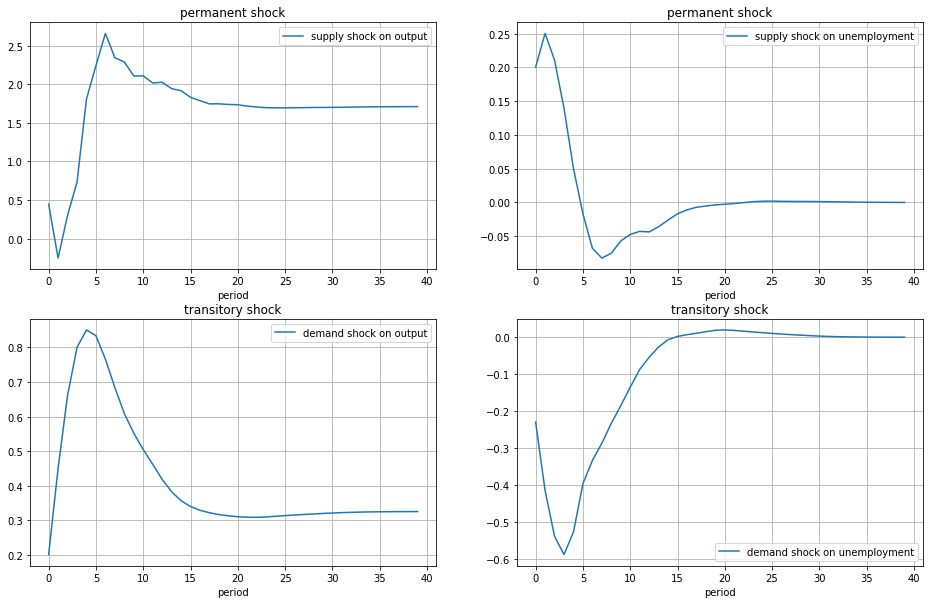

In [30]:
# Plot the IRFs

plt.figure(figsize=(16,10))
plt.subplot(221)
plt.plot(irf_cum["s_y"],label='supply shock on output')
plt.legend()
plt.xlabel('period')
plt.title('permanent shock')
plt.grid()
plt.subplot(222)
plt.plot(irf["s_u"],label='supply shock on unemployment')
plt.legend()
plt.xlabel('period')
plt.title('permanent shock')
plt.grid()
plt.subplot(223)
plt.plot(irf_cum["s_u"],label='demand shock on output')
plt.legend()
plt.xlabel('period')
plt.title('transitory shock')
plt.grid()
plt.subplot(224)
plt.plot(irf["d_u"],label='demand shock on unemployment')
plt.legend()
plt.xlabel('period')
plt.title('transitory shock')
plt.grid()
plt.show()

#### Simulation
Once we have the estimated structrual shocks we can reconstruct the time series

$$X_{t}^{c}=B^{c}X_{t-1}^{c}+A_0^{c}e_{t}$$

and by putting zeros in one of the $e_t$ we can shut down the effects of the
transitory or permanent shock.


In [68]:
'''
simulation
'''
c_A0 = np.vstack((A0,np.zeros([(num_lags-1)*num_vars,num_vars])))
#shut down a shock
ETA_D = ETA.copy()
ETA_D[:,0] = np.zeros((num_obs))
ETA_S = ETA.copy()
ETA_S[:,1] = np.zeros((num_obs))
X_sim = np.zeros([num_vars,num_lags])

for i in range(num_lags):
    
    X_sim[:,num_lags-i-1]=X.values[i,:]
    
X_sim = np.reshape(X_sim,(num_lags*num_vars,1),order='F')
X_sim = np.hstack((X_sim,np.zeros([num_lags*num_vars,num_obs-1])))
X_sim_D = X_sim.copy()
X_sim_S = X_sim.copy()

for t in range(num_obs-1):
    
    X_sim[:,t+1] = np.dot(c_Bhat,X_sim[:,t])   + np.dot(c_A0,ETA.T[:,t])
    X_sim_D[:,t+1] = np.dot(c_Bhat,X_sim_D[:,t]) + np.dot(c_A0,ETA_D.T[:,t])
    X_sim_S[:,t+1] = np.dot(c_Bhat,X_sim_S[:,t]) + np.dot(c_A0,ETA_S.T[:,t])

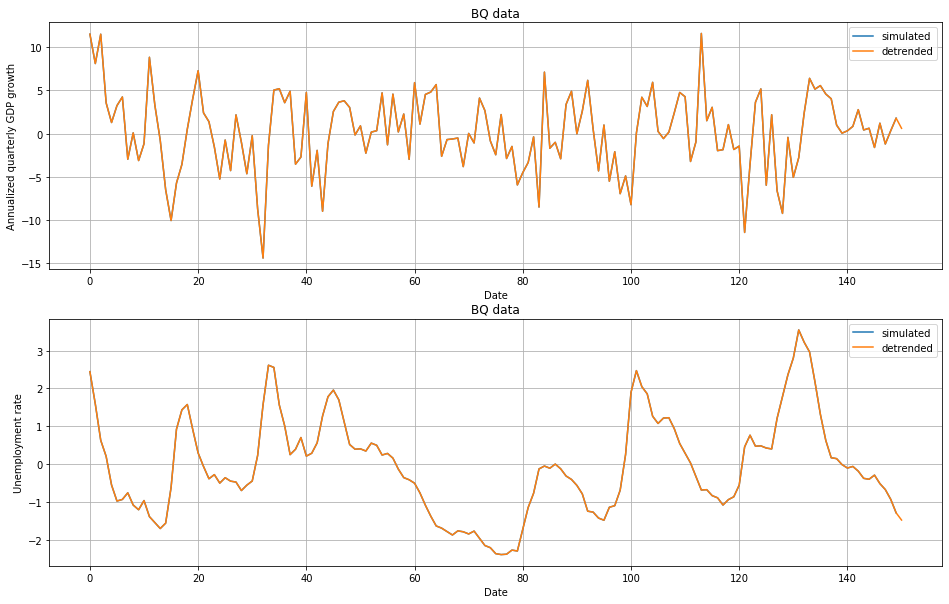

In [69]:
# Plot original data & simulated data
plt.figure(figsize=(16,10))
plt.subplot(211)
plt.plot(X_sim[0,:],label='simulated')
plt.plot(np.array(df['dys'][7:]),label='detrended')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Annualized quarterly GDP growth')
plt.title('BQ data')
plt.grid()
plt.subplot(212)
plt.plot(X_sim[1,:],label='simulated')
plt.plot(np.array(df['urates'][7:]),label='detrended')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Unemployment rate')
plt.title('BQ data')
plt.grid()
plt.show()

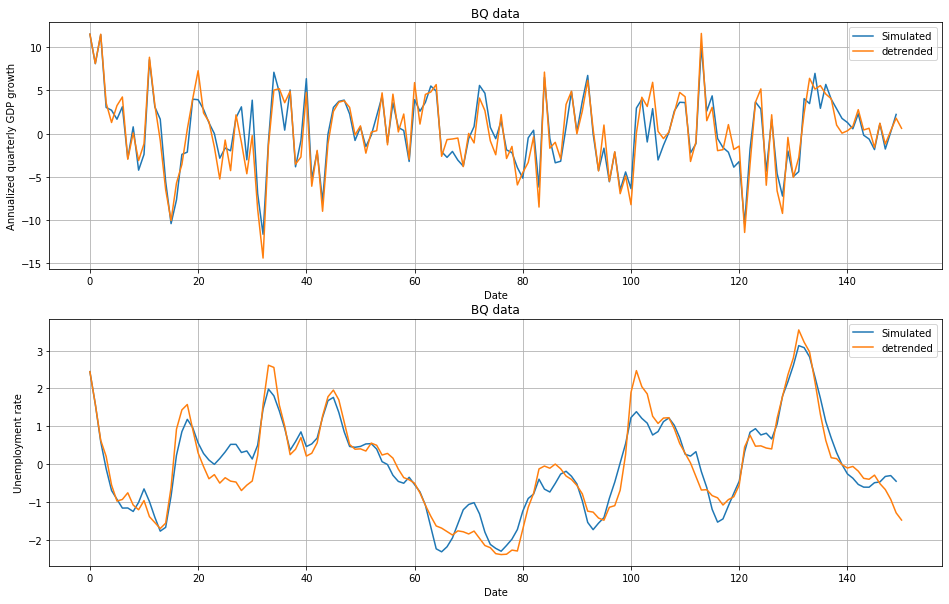

In [70]:
# Plot original data & simulated data
plt.figure(figsize=(16,10))
plt.subplot(211)
plt.plot(X_sim_D[0,:],label='Simulated')
plt.plot(np.array(df['dys'][7:]),label='detrended')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Annualized quarterly GDP growth')
plt.title('BQ data')
plt.grid()
plt.subplot(212)
plt.plot(X_sim_D[1,:],label='Simulated')
plt.plot(np.array(df['urates'][7:]),label='detrended')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Unemployment rate')
plt.title('BQ data')
plt.grid()
plt.show()

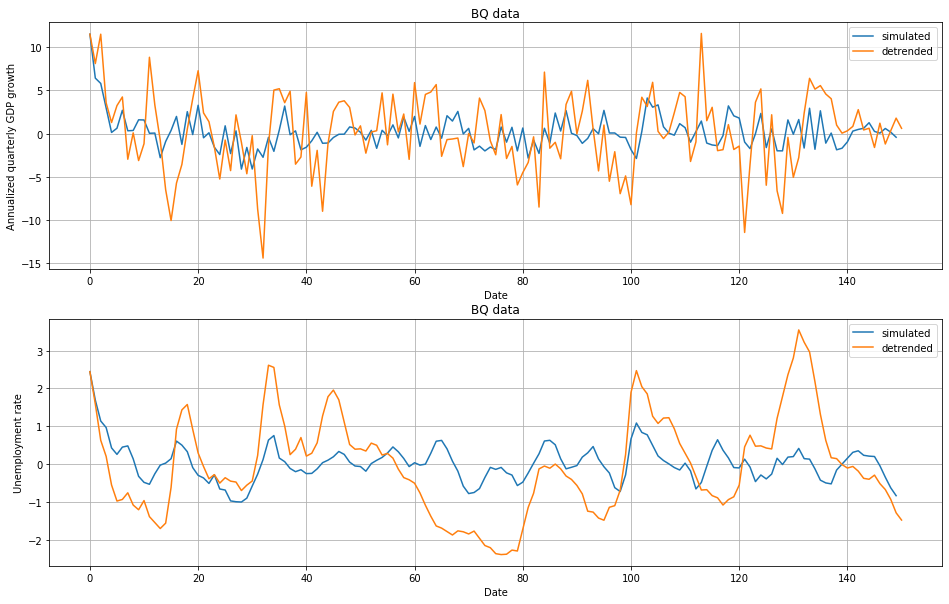

In [71]:
# Plot original data & simulated data
plt.figure(figsize=(16,10))
plt.subplot(211)
plt.plot(X_sim_S[0,:],label='simulated')
plt.plot(np.array(df['dys'][7:]),label='detrended')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Annualized quarterly GDP growth')
plt.title('BQ data')
plt.grid()
plt.subplot(212)
plt.plot(X_sim_S[1,:],label='simulated')
plt.plot(np.array(df['urates'][7:]),label='detrended')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Unemployment rate')
plt.title('BQ data')
plt.grid()
plt.show()

In [173]:
'''
We can build our own VAR Class
And we have options in how to program it
here with numpy
'''
class VAR_np_class2():
    
    def __init__(self,X,lags,num_impulses=40):
        
        self.X = X
        self.lags = lags
        self.num_vars = X.shape[1]
        self.num_obs = X.shape[0] - self.lags
        self.num_impulses = num_impulses
        
    def XLAGp(self):       
        XLAG     = np.vstack((np.empty((1,2)),self.X[0:-1,:]))
        for i in range(2,self.lags+1):
            tmp1 = np.vstack((np.empty((i,2)),self.X[0:-i,:]))
            XLAG = np.hstack((XLAG,tmp1))
        X2 = self.X[self.lags:,:]
        XLAG2    = XLAG[self.lags:,:]
        return X2, XLAG2
    
    def fit(self):
        X2, XLAG2 = self.XLAGp()
        Bhat = inv(XLAG2.T@XLAG2)@XLAG2.T@X2
        return Bhat
    
    def objective(self,x0,Mhat,Omegahat,num_vars):   
    
        A0 = np.reshape(x0,[self.num_vars,self.num_vars])  #grab starting values, and create a possible matrix  A(0)
        LR = Mhat@A0                             #LR effect given by multiplication of Mhat and A0
        H = A0@A0.T - Omegahat                   #A(0)*A(0).T should be equal to Omegahat, 
                                                 #as variance of shocks is identity
        H[0,1] = LR[0,1]                         #We add LR restriction
        H = H.flatten()
        return H                                 #each parameter in H must be equal to 0, including LR restriction
    
    def IRF(self):
        IRF  = np.zeros([self.num_impulses,self.num_vars,self.num_vars])
        
        Bhat = self.fit()
        c_Bhat = np.vstack((Bhat.T,np.hstack((np.identity((self.lags-1)*self.num_vars),
                                              np.zeros([(self.lags-1)*self.num_vars,self.num_vars]))))) 
        
        #Setting up for LR restriction
        c_Mhat = inv(np.identity(c_Bhat.shape[0])-c_Bhat)
        Mhat = c_Mhat[:2,:2]
        Temp = np.identity(c_Bhat.shape[0])
        #Estimated errors
        X2, XLAG2 = self.XLAGp()
        EPS = (X2 - XLAG2@Bhat)
        #estimated covariance matrix
        Omegahat = EPS.T@EPS/(self.num_obs - self.lags*self.num_vars)
        x0 = ((Omegahat**2)**.25).flatten() #Starting values, flatten is needed for root function below
        sol = root(objective,x0,args=(Mhat,Omegahat,self.num_vars)) # Solves F(X) = 0, where both X and 0 can be vectors
        A0   = sol.x.reshape([self.num_vars,self.num_vars]) 
        #the first shock (supply) should have a positive impact on unemployment (only redefines direction, and changes nothing)
        if A0[1,0] < 0: A0[:,0] = -A0[:,0]
        #the second shock (demand) should have a positive impact on output (only redefines direction, and changes nothing)
        if A0[0,1] < 0: A0[:,1] = -A0[:,1]
        #Estimating structural shocks, ETA
        F = inv(A0)
        ETA = EPS@F.T
        psi  = []
        Temp = np.identity(c_Bhat.shape[0])
        for t in range(self.num_impulses):
            psi_t = Temp[:self.num_vars,:self.num_vars] 
            IRF[t,:,:] = psi_t@A0         # store the IRF
            Temp = c_Bhat@Temp            # computes the exponent of the matrix
            #psi.append(psi_t)            # stores the matrices Psi (notations as in Hamilton)

        irf  = pd.DataFrame({i:IRF[i].flatten() for i in range(num_impulses)}).T #save IRFs into dataframe
        #irf.columns = ["s_y","d_y","s_u","d_u"]
        irf_cum = irf.cumsum() #output is expressed cumulatively

        return A0,EPS,ETA,irf,irf_cum
    
    def simulate(self):
        
        A0,EPS,ETA,irf,irf_cum = self.IRF()
        X_sim = np.zeros([self.num_vars,self.lags])
        G0_hat = np.vstack((np.eye(self.num_vars),np.zeros([(self.lags-1)*self.num_vars,self.num_vars])))
        for i in range(self.lags):
            X_sim[:,self.lags-i-1]=self.X[i,:]
    
        X_sim = np.reshape(X_sim,(self.lags*self.num_vars,1),order='F')
        X_sim = np.hstack((X_sim,np.zeros([self.lags*self.num_vars,self.num_obs-1])))        
        for t in range(self.num_obs-1):
            X_sim[:,t+1] = np.dot(c_Bhat,X_sim[:,t]) + np.dot(G0_hat,EPS.T[:,t])     
        return X_sim

In [178]:
'''
Bootstrap of the confidence intervals
'''
iter1 = 100
IRF_var = np.zeros([num_impulses*(num_vars*num_vars),iter1])
prova = VAR_np_class2(X.values,8)
A0,EPS,ETA,irf,irf_cum = prova.IRF()
G0_hat = np.vstack((np.eye(num_vars),np.zeros([(num_lags-1)*num_vars,num_vars])))
scale = np.sqrt(num_obs/(num_obs - num_lags*num_vars))
EPS_r = scale*EPS.copy()
for it in range(iter1):
    
    np.random.shuffle(EPS_r)    
    X_r = np.zeros([num_vars,num_lags])
    X_init_r = X.values.copy()
    np.random.shuffle(X_init_r)
    for i in range(num_lags):
        X_r[:,num_lags-i-1]=X_init_r[i,:]
    X_r = np.reshape(X_r,(num_lags*num_vars,1),order='F')
    X_r = np.hstack((X_r,np.zeros([num_lags*num_vars,num_obs-1])))        
    for t in range(num_obs-1):
        X_r[:,t+1] = np.dot(c_Bhat,X_r[:,t])+ np.dot(G0_hat,EPS_r.T[:,t])         
    prova = VAR_np_class2(X_r[0:2,:].T,8)
    A0_ci,EPS_ci,ETA_ci,irf_ci,irf_cum_ci = prova.IRF()
    irf_final_ci = pd.concat([irf_cum_ci[0],     #supply shock on output
                              irf_cum_ci[1],     #demand shock on output
                              irf_ci[2],         #supply shock on unemployment
                              irf_ci[3]],axis=1) #demand shock on unemployment
    IRF_var[:,it]  = np.reshape(np.array(irf_final_ci),(num_impulses*(num_vars*num_vars),1)).flatten()

In [179]:
# KEEP THE 5% - 95% IRF sorted 
IRF_var        = IRF_var.reshape(num_impulses,num_vars*num_vars,iter1)
IRF_var        = np.sort(IRF_var,axis=2)
IRF_varci      = IRF_var[:,:,[np.int(0.05*iter1),np.int(0.95*iter1)]]

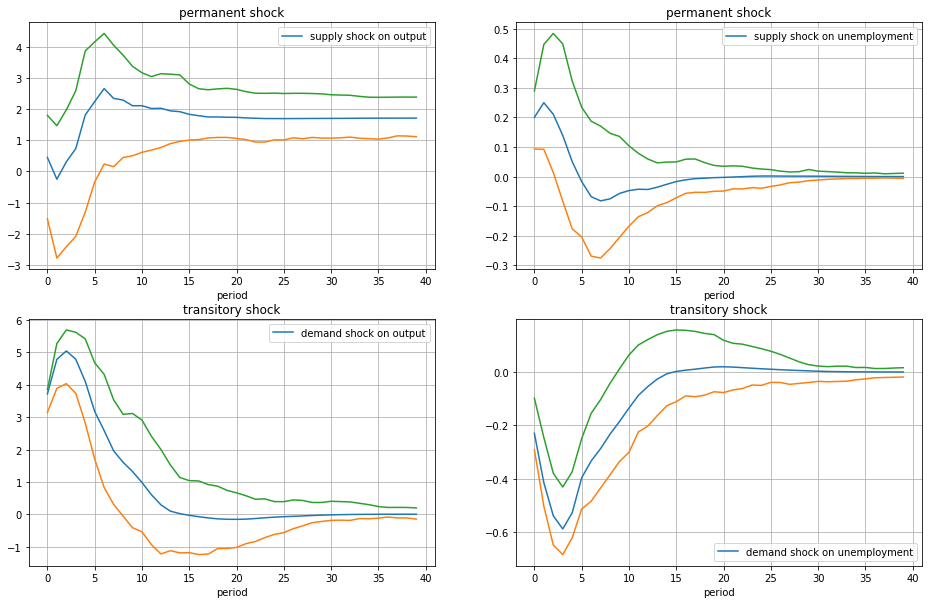

In [180]:
# Plot the IRFs with CI
plt.figure(figsize=(16,10))
plt.subplot(221)
plt.plot(irf_cum[0],label='supply shock on output')
plt.plot(IRF_varci[:,0,:])
plt.legend()
plt.xlabel('period')
plt.title('permanent shock')
plt.grid()
plt.subplot(222)
plt.plot(irf[2],label='supply shock on unemployment')
plt.plot(IRF_varci[:,2,:])
plt.legend()
plt.xlabel('period')
plt.title('permanent shock')
plt.grid()
plt.subplot(223)
plt.plot(irf_cum[1],label='demand shock on output')
plt.plot(IRF_varci[:,1,:])
plt.legend()
plt.xlabel('period')
plt.title('transitory shock')
plt.grid()
plt.subplot(224)
plt.plot(irf[3],label='demand shock on unemployment')
plt.plot(IRF_varci[:,3,:])
plt.legend()
plt.xlabel('period')
plt.title('transitory shock')
plt.grid()
plt.show()

#### Variance decomposition
$$FEV^{D}=E_{t_{0}}\left[\left(X_{t_{0}+s}-\widehat{X}_{t_{0}+s}\right)\left(X_{t_{0}+s}-\widehat{X}_{t_{0}+s}\right)^{\prime}\right]=\sum_{t=0}^{s-1}C_{t}\Omega C_{t}^{\prime}$$
$$\Omega=AA^{\prime}=\sum_{j=1}^{n_{vars}}a_{j}a_{j}^{\prime}$$

In [182]:
'''Vfrac_D(:,1,1) : variance of the first variable explained by varshock
   Vfrac_D(:,2,2) : variance of the second variable explained by varshock
   Vfrac_L : same for levels (cumulative response)'''

MSE1_D = np.zeros([num_impulses,num_vars,num_vars]) 
MSE2_D = np.zeros([num_impulses,num_vars,num_vars]) 
MSE1_t = np.zeros([num_vars,num_vars]) 
MSE2_t = np.zeros([num_vars,num_vars]) 
g1 = A0[:,:1] 
g2 = A0[:,1:2] 
Temp = np.identity(c_Bhat.shape[0])               # for i=1, Temp is Identity.
for t in range(num_impulses): 
    Psi_t = Temp[:num_vars,:num_vars]    # extracts the upper left block.
    
    MSE1_t = MSE1_t + np.dot(np.dot(Psi_t,g1),np.dot(g1.T,Psi_t.T))                        
    MSE2_t = MSE2_t + np.dot(np.dot(Psi_t,g2),np.dot(g2.T,Psi_t.T))
    MSE1_D[t,:,:] = MSE1_t 
    MSE2_D[t,:,:] = MSE2_t 
    Temp = np.dot(c_Bhat,Temp)

Vfrac_D1 = MSE1_D/(MSE1_D+MSE2_D)
Vfrac_D2 = MSE2_D/(MSE1_D+MSE2_D)

In [183]:
vfrac_D1 = pd.DataFrame({i:Vfrac_D1[i].flatten() for i in range(num_impulses)}).T #save Vardec into dataframe
vfrac_D1.columns = ["vs_dy","","","vs_u"]


In [184]:
vfrac_D2 = pd.DataFrame({i:Vfrac_D2[i].flatten() for i in range(num_impulses)}).T #save Vardec into dataframe
vfrac_D2.columns = ["vd_dy","","","vd_u"]

In [185]:
'''Vfrac_D(:,1,1) : variance of the first variable explained by varshock
   Vfrac_D(:,2,2) : variance of the second variable explained by varshock
   Vfrac_L : same for levels (cumulative response)'''

MSE1_L = np.zeros([num_impulses,num_vars,num_vars]) 
MSE2_L = np.zeros([num_impulses,num_vars,num_vars]) 
MSE1_t = np.zeros([num_vars,num_vars]) 
MSE2_t = np.zeros([num_vars,num_vars]) 
g1 = A0[:,:1] 
g2 = A0[:,1:2] 
Temp = np.identity(c_Bhat.shape[0])      # for i=1, Temp is Identity.
for t in range(num_impulses): 
    Psi_t = Temp[:num_vars,:num_vars]    # extracts the upper left block.
    
    MSE1_t = MSE1_t + np.dot(np.dot(Psi_t,g1),np.dot(g1.T,Psi_t.T))                        
    MSE2_t = MSE2_t + np.dot(np.dot(Psi_t,g2),np.dot(g2.T,Psi_t.T))
    MSE1_L[t,:,:] = MSE1_t 
    MSE2_L[t,:,:] = MSE2_t 
    Temp = np.identity(c_Bhat.shape[0]) + np.dot(c_Bhat,Temp)

Vfrac_L1 = MSE1_L/(MSE1_L+MSE2_L)
Vfrac_L2 = MSE2_L/(MSE1_L+MSE2_L)


In [186]:
vfrac_L1 = pd.DataFrame({i:Vfrac_L1[i].flatten() for i in range(num_impulses)}).T #save vardec into dataframe
vfrac_L1.columns = ["vs_y","","",""]
vfrac_L2 = pd.DataFrame({i:Vfrac_L2[i].flatten() for i in range(num_impulses)}).T #save IRFs into dataframe
vfrac_L2.columns = ["vd_y","","",""]

In [192]:
Table_2 = pd.concat([vfrac_L2["vd_y"],vfrac_D2["vd_u"]],axis=1)

In [194]:
Table_2.loc[[0,1,2,3,7,11,39]]

,vd_y,vd_u
0,0.985683,0.568057
1,0.992874,0.686362
2,0.994306,0.777736
3,0.989610,0.837784
7,0.849223,0.891727
11,0.762365,0.892212
39,0.506027,0.890397
